# Notebook 4 – Classifying EMG Segments with SVM (RBF Kernel)

In this notebook, we will build a **classifier** to predict the task label (T1–T7)  
from EMG features using a **Support Vector Machine (SVM)** with an **RBF kernel**.

We will:

1. Load the feature dataset created in Notebook 3:
   - `ABC2026_EMG2_ACTION_SEGMENTS_mean_std_rms.csv`
2. Prepare the data for machine learning:
   - Separate features (X) and labels (y)
   - Drop non-feature columns (`subject_id`, `trial_id`)
   - Encode labels (T1–T7) as numbers
   - Standardize features
3. Split the data into:
   - Training set
   - Test set
4. Train an SVM classifier with an RBF kernel.
5. Evaluate the model:
   - Accuracy
   - Classification report (precision, recall, f1-score)
   - Confusion matrix (as a heatmap)


In [6]:


from google.colab import drive
drive.mount('/content/drive')

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load the EMG Feature Dataset

We now load the CSV file generated in Notebook 3:

- Path: `MindRove_Data/datasets/ABC2026_EMG2_ACTION_SEGMENTS_mean_std_rms.csv`

We will:
- Read the CSV into a pandas DataFrame.
- Print the shape and show the first few rows.
- Check the label distribution.


In [7]:
# 2. Load the dataset

DATASET_ROOT = "/content/drive/MyDrive/MindRove_Data/datasets"
DATASET_NAME = "ABC2026_EMG2_ACTION_SEGMENTS_mean_std_rms.csv"

dataset_path = os.path.join(DATASET_ROOT, DATASET_NAME)
print("Dataset path:", dataset_path)

df = pd.read_csv(dataset_path)

print("\nDataset shape (rows, columns):", df.shape)
display(df.head())

print("\nColumns:")
print(df.columns.tolist())

print("\nLabel distribution:")
print(df["label"].value_counts().sort_index())


Dataset path: /content/drive/MyDrive/MindRove_Data/datasets/ABC2026_EMG2_ACTION_SEGMENTS_mean_std_rms.csv

Dataset shape (rows, columns): (238, 27)


,subject_id,trial_id,label,Channel1_MEAN,Channel1_STD,Channel1_RMS,Channel2_MEAN,Channel2_STD,Channel2_RMS,Channel3_MEAN,...,Channel5_RMS,Channel6_MEAN,Channel6_STD,Channel6_RMS,Channel7_MEAN,Channel7_STD,Channel7_RMS,Channel8_MEAN,Channel8_STD,Channel8_RMS
0,S04,1,T1,0.000142,16.940679,16.940679,-0.000016,18.351788,18.351788,-0.000255,...,12.631625,0.000182,14.375861,14.375861,-0.000318,6.141118,6.141118,-0.000209,7.492731,7.492731
1,S04,1,T2,-0.000632,9.308019,9.308019,0.000006,14.219567,14.219567,0.000682,...,6.375804,0.002192,10.148740,10.148741,0.002676,17.934855,17.934855,0.000863,8.019464,8.019464
2,S04,1,T3,-0.001802,4.771755,4.771755,-0.000516,4.735977,4.735977,0.000422,...,2.871941,0.001773,2.752110,2.752111,0.000771,1.872228,1.872228,0.000012,2.811738,2.811738
3,S04,1,T4,0.004231,10.426004,10.426005,0.005728,11.293126,11.293127,0.005445,...,15.493916,-0.008712,23.869243,23.869245,-0.006601,14.154035,14.154036,0.001705,4.925717,4.925717
4,S04,1,T5,-0.004848,7.232410,7.232412,-0.006111,9.743597,9.743599,-0.007306,...,7.719175,-0.000990,10.844153,10.844153,-0.000276,14.427819,14.427819,-0.002900,3.963111,3.963112



Columns:
['subject_id', 'trial_id', 'label', 'Channel1_MEAN', 'Channel1_STD', 'Channel1_RMS', 'Channel2_MEAN', 'Channel2_STD', 'Channel2_RMS', 'Channel3_MEAN', 'Channel3_STD', 'Channel3_RMS', 'Channel4_MEAN', 'Channel4_STD', 'Channel4_RMS', 'Channel5_MEAN', 'Channel5_STD', 'Channel5_RMS', 'Channel6_MEAN', 'Channel6_STD', 'Channel6_RMS', 'Channel7_MEAN', 'Channel7_STD', 'Channel7_RMS', 'Channel8_MEAN', 'Channel8_STD', 'Channel8_RMS']

Label distribution:
label
T1    34
T2    34
T3    34
T4    34
T5    34
T6    34
T7    34
Name: count, dtype: int64


## 2. Prepare Features (X) and Labels (y)

The dataset contains:

- Metadata columns:
  - `subject_id`
  - `trial_id`
- Target label:
  - `label` (T1–T7)
- Feature columns:
  - EMG features, e.g. `Channel1_MEAN`, `Channel1_STD`, `Channel1_RMS`, ...

Steps:

1. **Drop** the metadata and label columns from X:
   - `X = df.drop(['subject_id', 'trial_id', 'label'], axis=1)`
2. **Keep** the label column as y:
   - `y = df['label']`
3. Encode string labels (T1–T7) into integers using `LabelEncoder`.


In [8]:
# 3. Build feature matrix X and label vector y

# Drop non-feature columns
X = df.drop(columns=["subject_id", "trial_id", "label"])
y = df["label"]

print("Feature matrix shape X:", X.shape)
print("Label vector shape y:", y.shape)

# Encode string labels (e.g. "T1" -> 0, "T2" -> 1, ...)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("\nOriginal labels:", sorted(y.unique()))
print("Encoded classes :", label_encoder.classes_)
print("Example y_encoded:", y_encoded[:10])


Feature matrix shape X: (238, 24)
Label vector shape y: (238,)

Original labels: ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
Encoded classes : ['T1' 'T2' 'T3' 'T4' 'T5' 'T6' 'T7']
Example y_encoded: [0 1 2 3 4 5 6 0 1 2]


## 3. Train–Test Split

We will split the data into:

- **Training set**: 80% of the samples  
- **Test set**: 20% of the samples  

We use:

```python
train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)



In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)


X_train shape: (190, 24)
X_test  shape: (48, 24)
y_train shape: (190,)
y_test  shape: (48,)


## 4. Standardization and SVM with RBF Kernel


1. **Fit a `StandardScaler` on `X_train`**:
   - Subtract the mean
   - Divide by the standard deviation
2. **Transform both** `X_train` and `X_test` using this scaler.
3. Train an **SVM classifier** with:
   - `kernel='rbf'` (Radial Basis Function)
   - Example hyperparameters:
     - `C = 1.0`
     - `gamma = 'scale'`

We will:

- Train the model on the training set.
- Predict on the test set.
- Compute accuracy, classification report, and confusion matrix.


In [10]:
# 5. Standardize features and train SVM with RBF kernel

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Define SVM classifier with RBF kernel
svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    random_state=42
)

# Train the model
svm_clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svm_clf.predict(X_test_scaled)

# Evaluate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {test_accuracy:.4f}")


Test accuracy: 0.6250


## 5. Detailed Evaluation

We will:

1. Print a **classification report**:
   - Precision
   - Recall
   - F1-score
   - Support (number of samples)
2. Plot a **confusion matrix**:
   - Rows = true labels
   - Columns = predicted labels
   - Helps us see which tasks are confused with each other.


Classification report:

              precision    recall  f1-score   support

          T1       1.00      1.00      1.00         6
          T2       0.60      0.86      0.71         7
          T3       0.43      0.43      0.43         7
          T4       0.83      0.71      0.77         7
          T5       0.62      0.71      0.67         7
          T6       0.33      0.43      0.38         7
          T7       1.00      0.29      0.44         7

    accuracy                           0.62        48
   macro avg       0.69      0.63      0.63        48
weighted avg       0.68      0.62      0.62        48

Confusion matrix (raw counts):
[[6 0 0 0 0 0 0]
 [0 6 0 1 0 0 0]
 [0 0 3 0 0 4 0]
 [0 0 0 5 2 0 0]
 [0 1 1 0 5 0 0]
 [0 2 1 0 1 3 0]
 [0 1 2 0 0 2 2]]


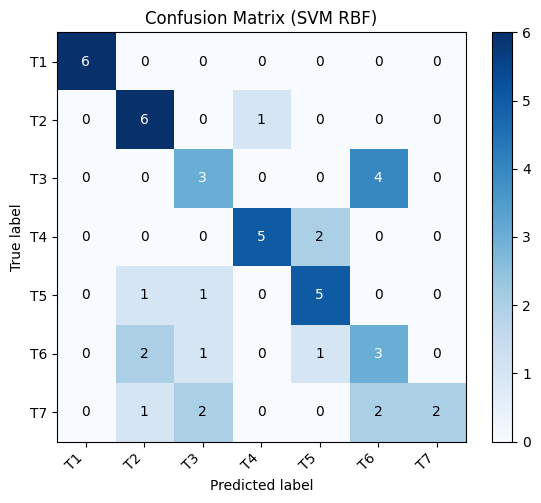

In [12]:
# 6. Classification report and confusion matrix

# Classification report
print("Classification report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (raw counts):")
print(cm)

# Plot confusion matrix as a heatmap with light blue colors
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")  # <<< CHANGE HERE
ax.set_title("Confusion Matrix (SVM RBF)")
plt.colorbar(im, ax=ax)

# Tick labels
ax.set_xticks(np.arange(len(label_encoder.classes_)))
ax.set_yticks(np.arange(len(label_encoder.classes_)))
ax.set_xticklabels(label_encoder.classes_)
ax.set_yticklabels(label_encoder.classes_)

plt.xlabel("Predicted label")
plt.ylabel("True label")

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="black" if cm[i, j] < cm.max()/2 else "white"
        )

plt.tight_layout()
plt.show()

